In [16]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt



In [18]:
image_size=256
batch_size=32

In [19]:
df=tf.keras.preprocessing.image_dataset_from_directory('PlantVillage',shuffle=True,
                                                   image_size = (image_size,image_size),
                                                   batch_size=batch_size)


Found 2152 files belonging to 3 classes.


In [20]:
dF_class=df.class_names

In [21]:
dF_class

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [22]:
len(df)

68

In [23]:
68*32 
#u got an idea y it was showing 68 bcz 32 is the batch size

2176

In [24]:
for image_batch,label_batch in df.take(1):
    print(image_batch[0].numpy)
    print(label_batch[0])

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[101., 103., 116.],
        [102., 104., 117.],
        [103., 105., 118.],
        ...,
        [155., 156., 174.],
        [159., 160., 178.],
        [160., 161., 179.]],

       [[ 95.,  97., 110.],
        [ 99., 101., 114.],
        [105., 107., 120.],
        ...,
        [164., 165., 183.],
        [162., 163., 181.],
        [159., 160., 178.]],

       [[116., 118., 131.],
        [108., 110., 123.],
        [101., 103., 116.],
        ...,
        [157., 158., 176.],
        [152., 153., 171.],
        [150., 151., 169.]],

       ...,

       [[ 96.,  99., 118.],
        [ 78.,  81., 100.],
        [113., 116., 135.],
        ...,
        [143., 148., 167.],
        [142., 147., 166.],
        [135., 140., 159.]],

       [[ 94.,  97., 116.],
        [101., 104., 123.],
        [127., 130., 149.],
        ...,
        [163., 168., 187.],
        [162., 167., 186.],
       

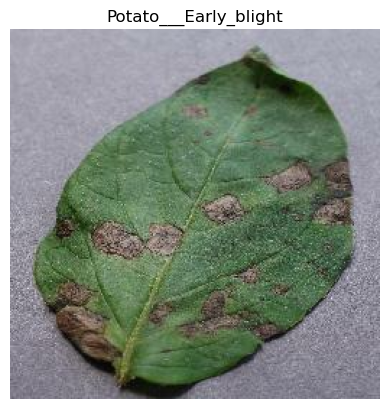

In [25]:
for image_batch,label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(dF_class[label_batch[0]])
    plt.axis("off")

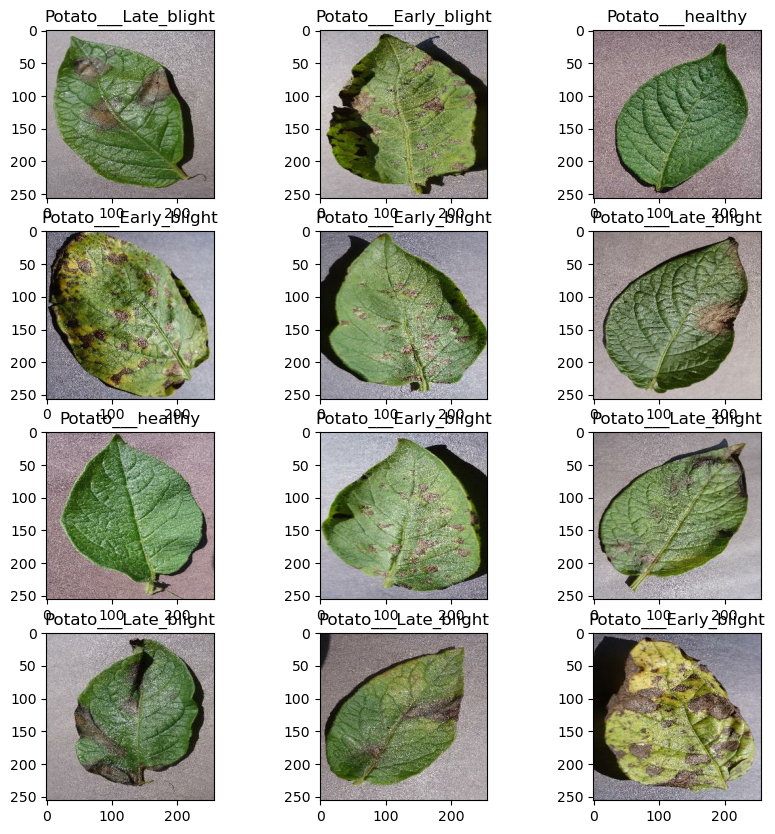

In [26]:
#if i have to see multiple image with classs  
#no of image is 12
plt.figure(figsize=(10,10))
for image_batch,label_batch in df.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(dF_class[label_batch[i]])
        
        

In [27]:
80% ==>train
10% ==>validation
10% ==>test

#so to divide this we create the function


SyntaxError: invalid syntax (1826458239.py, line 1)

In [28]:
def get_dateset_train_test(df,train_size=0.8,test_size=0.1,validation_size=0.1,shuffle=True,shuffle_size=1000):
    
    if shuffle:
        df=df.shuffle(shuffle_size,seed=12)
    
    df_size=len(df)
    tr_size=int(df_size*train_size)
    train_df=df.take(tr_size)
    
    val_s=int(df_size*validation_size)
    val_df=df.skip(tr_size).take(val_s)
    
    test_df=df.skip(tr_size).skip(val_s)
    
    
    
    
    return train_df,test_df,val_df

In [29]:
train_df,test_df,val_df=get_dateset_train_test(df)

In [30]:
len(train_df)

54

In [31]:
len(test_df)

8

In [32]:
len(val_df)

6

In [33]:
train_df=train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df=val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df=test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [36]:
input_shape=(batch_size,image_size,image_size,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
])

In [37]:
model.build(input_shape)

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [39]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [40]:
history=model.fit(
    train_df,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_df
)

Epoch 1/20
54/54 [==============================] - 189s 2s/step - loss: 0.9117 - accuracy: 0.4890 - val_loss: 0.8670 - val_accuracy: 0.4740
Epoch 2/20
54/54 [==============================] - 122s 2s/step - loss: 0.8186 - accuracy: 0.5845 - val_loss: 0.7040 - val_accuracy: 0.6823
Epoch 3/20
54/54 [==============================] - 122s 2s/step - loss: 0.6050 - accuracy: 0.7170 - val_loss: 0.5960 - val_accuracy: 0.7292
Epoch 4/20
54/54 [==============================] - 122s 2s/step - loss: 0.4192 - accuracy: 0.8264 - val_loss: 0.3025 - val_accuracy: 0.8906
Epoch 5/20
54/54 [==============================] - 122s 2s/step - loss: 0.3183 - accuracy: 0.8779 - val_loss: 0.2303 - val_accuracy: 0.9062
Epoch 6/20
54/54 [==============================] - 122s 2s/step - loss: 0.2424 - accuracy: 0.9074 - val_loss: 0.1880 - val_accuracy: 0.9427
Epoch 7/20
54/54 [==============================] - 122s 2s/step - loss: 0.1672 - accuracy: 0.9334 - val_loss: 0.1823 - val_accuracy: 0.9323
Epoch 8/20
54

In [43]:
model.history

In [42]:
score=model.evaluate(test_df)

8/8 [==============================] - 6s 563ms/step - loss: 0.1063 - accuracy: 0.9648


In [44]:
history.history.key()

AttributeError: 'dict' object has no attribute 'key'

In [45]:
history.history['accuracy']

[0.48900464177131653,
 0.5844907164573669,
 0.7170138955116272,
 0.8263888955116272,
 0.8778935074806213,
 0.9074074029922485,
 0.9334490895271301,
 0.9519675970077515,
 0.953125,
 0.9091435074806213,
 0.9699074029922485,
 0.9652777910232544,
 0.9739583134651184,
 0.9646990895271301,
 0.9820601940155029,
 0.9658564925193787,
 0.9826388955116272,
 0.9814814925193787,
 0.9785879850387573,
 0.9803240895271301]

In [46]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [47]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'training and validation accuracy')

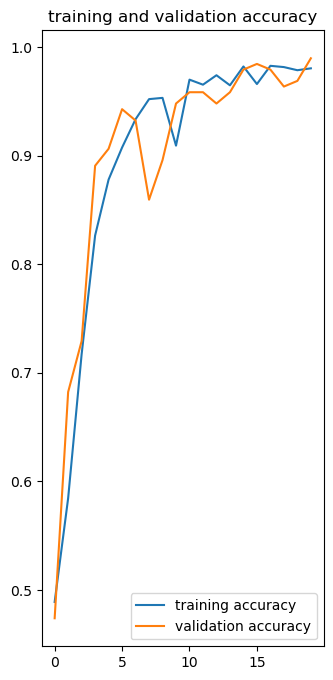

In [49]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),acc,label='training accuracy')
plt.plot(range(20),val_acc,label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

In [51]:
import numpy as np

first images to predict
actual label :  Potato___Late_blight
1/1 [==============================] - 0s 41ms/step
predicted label Potato___Late_blight


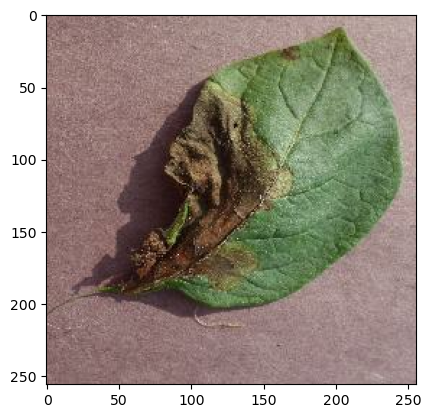

In [60]:
for image_batch, labels_batch in test_df.take(1):
    first_image= image_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    
    print("first images to predict")
    plt.imshow(first_image)
    print('actual label : ',dF_class[first_label])
    
    batch_prediction=model.predict(image_batch)
    print('predicted label',dF_class[np.argmax(batch_prediction[0])])

In [73]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0) #creating the batch
    
    prediction = model.predict(img_array)
    
    pre_class= dF_class[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])),2)
    return pre_class , confidence

1/1 [==============================] - 0s 16ms/step


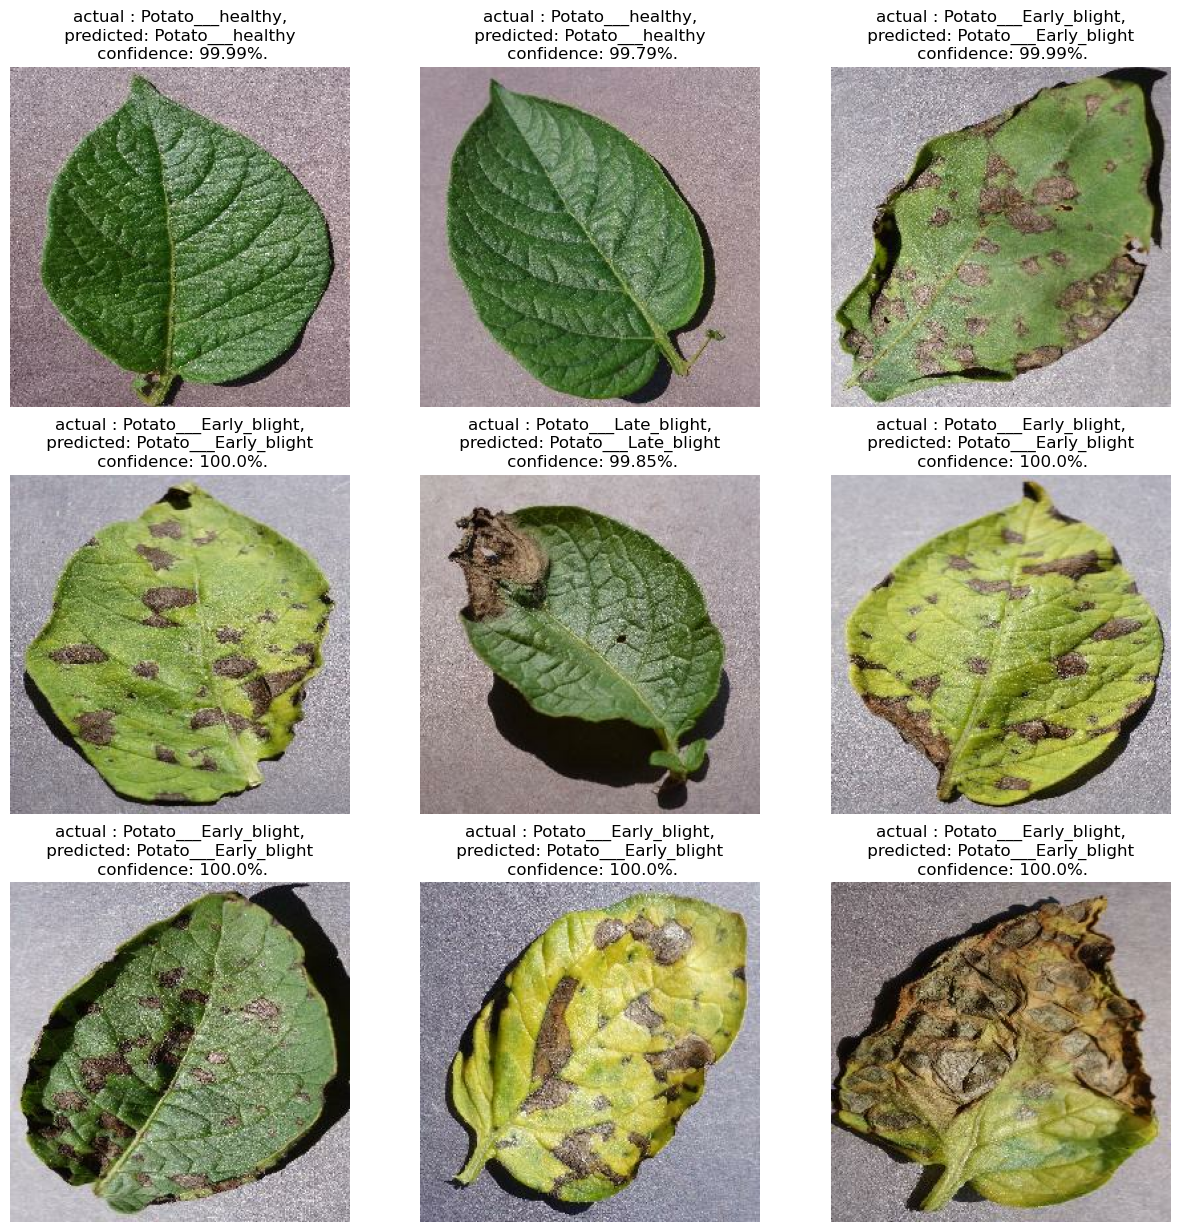

In [77]:
plt.figure(figsize=(15,15))
for image , label in test_df.take(1):
    for i in range(9):
        ax =plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        
        prediction_class , confidence= predict(model,image[i].numpy())
        actual_class=dF_class[label[i]]
        plt.title(f"actual : {actual_class},\n predicted: {prediction_class} \n confidence: {confidence}%.")
        plt.axis('off')

In [82]:
model_version =1
model.save(f'/Desktop/dataset_deep_learning/model{model_version}')

INFO:tensorflow:Assets written to: /Desktop/dataset_deep_learning/model1\assets


INFO:tensorflow:Assets written to: /Desktop/dataset_deep_learning/model1\assets


In [ ]:
#auto increment our model
import os
model_version=max([int (i) for i in os.listdir("model"))+1
model.save(f"/model/{model_version}")